# **NDD Perturb-seq project**
### Preprocessing iNeuron data in python because it is too big for R initially

### Importing packages

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io

In [2]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

### Importing raw H5 data for iNeurons

In [3]:
adata = sc.read_10x_h5("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/filtered_feature_bc_matrix.h5", gex_only=False)

/home/toofastdan/apps/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
#adata = sc.read_mtx("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/batch1/matrix.mtx.gz")
#adata.obs_names = np.loadtxt("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/batch1/barcodes.tsv.gz", dtype=str, delimiter="\t")
#var = np.loadtxt("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/batch1/features.tsv.gz", dtype=str, delimiter="\t")
#adata.var_names = var[:,0]

In [4]:
adata

AnnData object with n_obs × n_vars = 450370 × 40774
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name'

In [5]:
adata.var["feature_types"].unique()

array(['Gene Expression', 'CRISPR Guide Capture'], dtype=object)

### Importing protospacer calls per cell to determine which cells got which gRNAs

In [6]:
grna_calls = pd.read_csv("/mnt/mass_storage1/mass_storage_projects/NDD_perturb/NDD-neu-none-aggr/count/protospacer_calls_per_cell.csv")

In [7]:
num_grna_calls = grna_calls["num_features"].value_counts().reset_index()
num_grna_calls

,num_features,count
0,1,283998
1,2,83797
2,3,22646
3,4,6091
4,5,1967
5,6,723
6,7,347
7,8,236
8,9,124
9,10,76


### Plotting the distribution of cells and the gRNA counts

In [ ]:
# Value counts
num_grna_calls = grna_calls["num_features"].value_counts().reset_index()

# Grouping all cells with >5 gRNAs per cell
num_5_grna_calls = num_grna_calls[num_grna_calls["num_features"]>5].sum()
num_5_grna_calls

# Making a plottable dataframe
num_grna_calls = num_grna_calls[num_grna_calls["num_features"]<5]
num_grna_calls.loc[len(num_grna_calls)] = [0, adata.n_obs - grna_calls.shape[0]]
num_grna_calls.loc[len(num_grna_calls)] = [">5", num_5_grna_calls["count"]]
category_types = CategoricalDtype(categories=["0", "1", "2", "3", "4", ">5"], ordered=True)
num_grna_calls["num_features"] = num_grna_calls["num_features"].astype(str).astype(category_types)
num_grna_calls

,num_features,count
0,1,283998
1,2,83797
2,3,22646
3,4,6091
4,0,50267
5,>5,1604


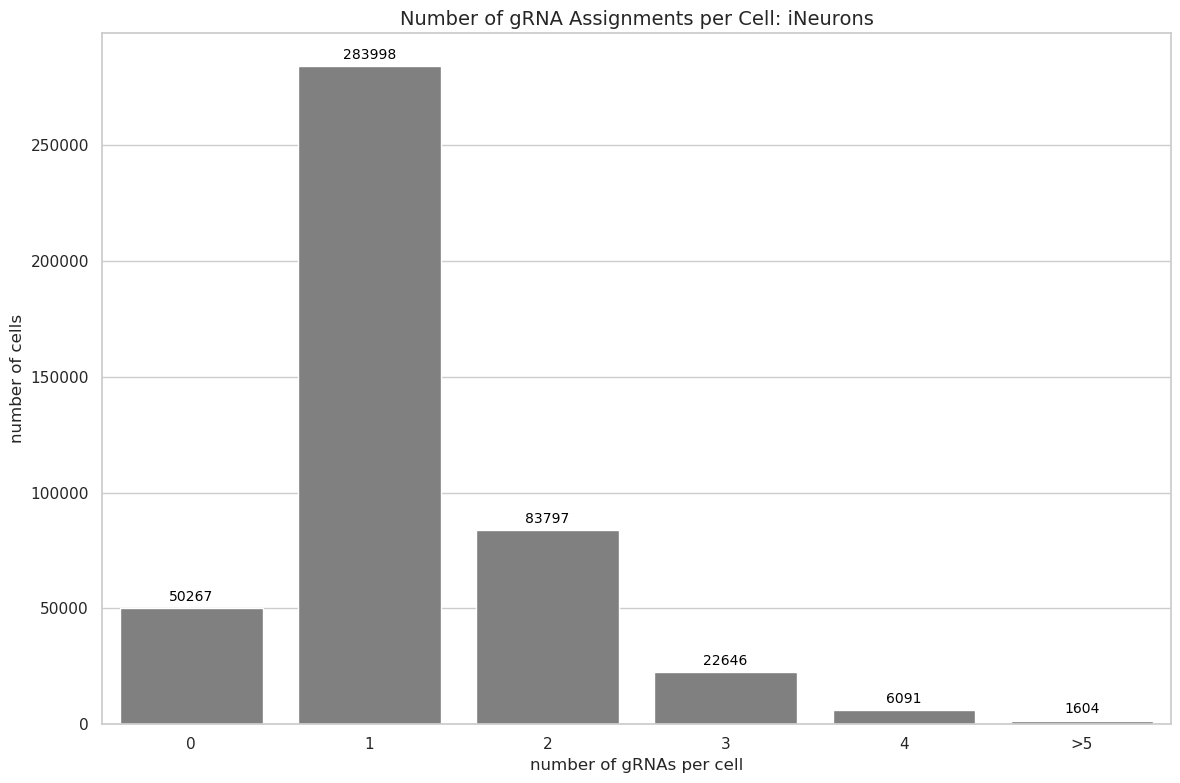

In [ ]:
# Set style
sns.set(style="whitegrid")

# Create a barplot for gRNA count distribution per cell
plt.figure(figsize=(12,8))
ax = sns.barplot(x="num_features", y="count", data=num_grna_calls, color="grey")

# Adding labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3),
                textcoords='offset points')

# Labels and title
ax.set_xlabel("number of gRNAs per cell", fontsize=12)
ax.set_ylabel("number of cells", fontsize=12)
ax.set_title("Number of gRNA Assignments per Cell: iNeurons", fontsize=14)

plt.tight_layout()

# Exporting the plot
#plt.savefig("iNeuron_figures/guide_counts_histogram.png", dpi=300)

# Showing the plot
plt.show()

## Filtering for cells that got only 1 gRNA!

In [10]:
# Filtering for cells that got 1 gRNA only
grna_calls_filt = grna_calls[grna_calls["num_features"]==1]

In [11]:
# Filtering anndata for cells that only got 1 gRNA
adata_filt = adata[adata.obs_names.isin(grna_calls_filt["cell_barcode"])].copy()

/home/toofastdan/apps/miniconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Calculating mitochondrial counts

In [12]:
adata_filt.var["mt"] = adata_filt.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata_filt, qc_vars="mt", inplace=True)

In [13]:
adata_filt.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
AAACCAAAGATTACCG-1,5811,8.667680,18729.0,9.837882,17.956111,23.530354,30.861231,44.385712,766.0,6.642487,4.089914
AAACCAAAGCAACCGT-1,5344,8.583917,15182.0,9.627932,18.284811,24.028455,31.721776,45.218021,504.0,6.224558,3.319721
AAACCAAAGCATCGCG-1,5591,8.629092,18921.0,9.848081,23.244015,28.803974,36.250727,49.484700,497.0,6.210600,2.626711
AAACCAAAGCATCTAG-1,4998,8.516993,14549.0,9.585346,22.640731,28.118771,35.486975,48.649392,377.0,5.934894,2.591243
AAACCAAAGCTCACCC-1,5730,8.653645,18464.0,9.823632,18.706672,24.577556,32.176127,45.797227,602.0,6.401917,3.260399
...,...,...,...,...,...,...,...,...,...,...,...
GTTGTGCAGGGTTCCG-8,5753,8.657651,18213.0,9.809946,19.123703,24.647230,32.065009,45.500467,505.0,6.226537,2.772745
GTTGTGGGTAGGACTT-8,5085,8.534247,13941.0,9.542661,19.123449,24.840399,32.465390,45.850369,302.0,5.713733,2.166272
GTTGTGGGTGGGATAA-8,4228,8.349721,10117.0,9.222072,20.470495,26.163883,33.547494,47.089058,215.0,5.375278,2.125136
GTTGTGGGTGGTTGAT-8,8965,9.101195,50451.0,10.828777,17.295990,22.566451,29.565321,42.385681,1248.0,7.130098,2.473687


In [ ]:
# Making all cell barcodes unique
adata_filt.var_names_make_unique()

### Plotting QC metrics and filtering for nCounts and mitochondrial counts

In [15]:
# Number of genes detected per cell
p1_qlow = np.quantile(adata_filt.obs["n_genes_by_counts"], 0.05)
p1_qhigh = np.quantile(adata_filt.obs["n_genes_by_counts"], 0.95)
print(p1_qlow, p1_qhigh)

# Fraction of reads mapping to mitochondrial genes
p3_qlow = np.quantile(adata_filt.obs["pct_counts_mt"], 0.05)
p3_qhigh = np.quantile(adata_filt.obs["pct_counts_mt"], 0.95)
print(p3_qlow, p3_qhigh)

3879.0 7332.0
1.882476383447647 4.014726209640502


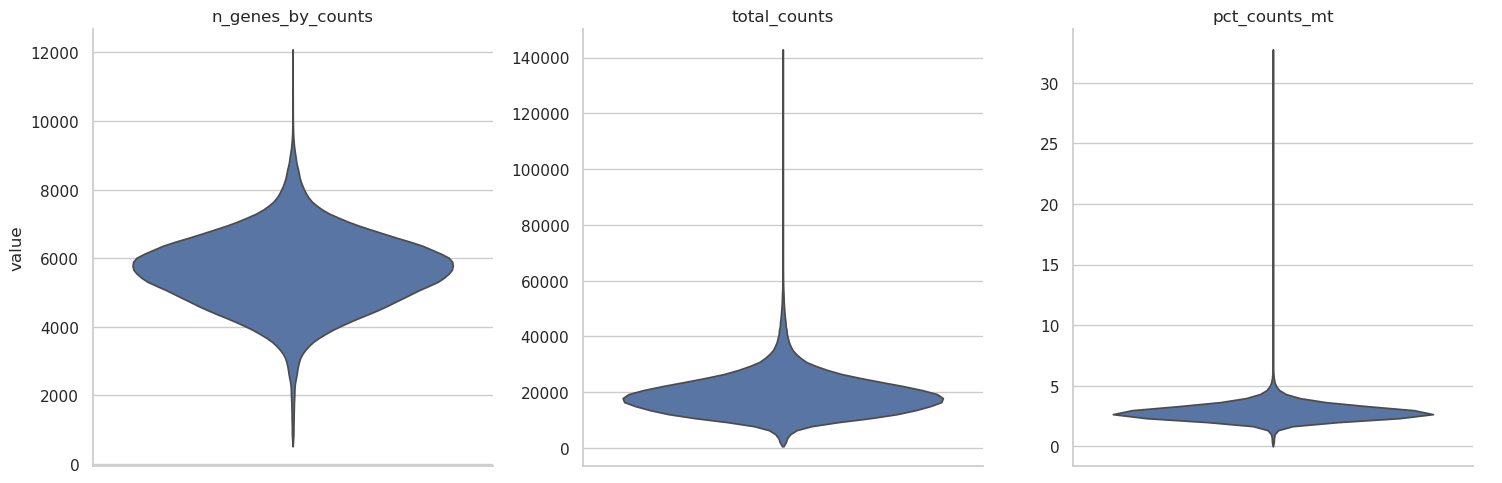

In [16]:
sc.pl.violin(
    adata_filt,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    stripplot=False,
    multi_panel=True,
)

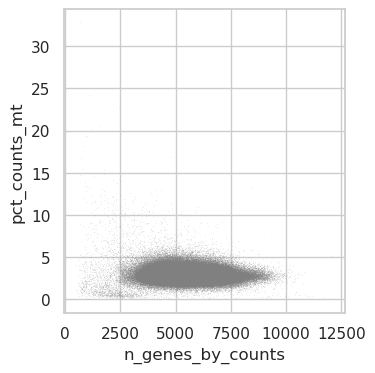

In [17]:
sc.pl.scatter(adata_filt, "n_genes_by_counts", "pct_counts_mt")

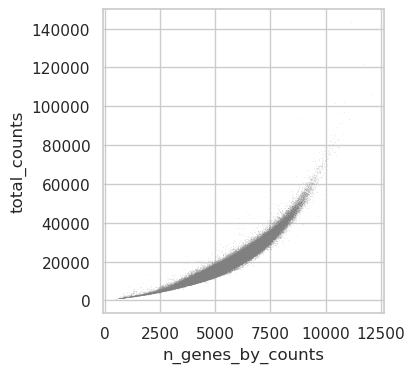

In [18]:
sc.pl.scatter(adata_filt, "n_genes_by_counts", "total_counts")

In [19]:
# Apply filtering criteria
adata_filt = adata_filt[
    (adata_filt.obs["n_genes_by_counts"] > p1_qlow) &
    (adata_filt.obs["n_genes_by_counts"] < p1_qhigh) &
    (adata_filt.obs["pct_counts_mt"] > p3_qlow) &
    (adata_filt.obs["pct_counts_mt"] < p3_qhigh)
].copy()

In [20]:
adata_filt

AnnData object with n_obs × n_vars = 232146 × 40774
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [21]:
adata_filt.obs_names

Index(['AAACCAAAGCAACCGT-1', 'AAACCAAAGCATCGCG-1', 'AAACCAAAGCATCTAG-1',
       'AAACCAAAGCTCACCC-1', 'AAACCAAAGGCAACAG-1', 'AAACCAAAGGCCACAT-1',
       'AAACCAAAGGCTGGTT-1', 'AAACCAAAGGTAGGTG-1', 'AAACCAAAGGTGCTGT-1',
       'AAACCAGCAATATGCC-1',
       ...
       'GTTGTGCAGCATGGAG-8', 'GTTGTGCAGCCATATG-8', 'GTTGTGCAGCCGTTGG-8',
       'GTTGTGCAGCGCGTCA-8', 'GTTGTGCAGCTAGGAG-8', 'GTTGTGCAGGCGGAGT-8',
       'GTTGTGCAGGGTTCCG-8', 'GTTGTGGGTAGGACTT-8', 'GTTGTGGGTGGGATAA-8',
       'GTTGTGGGTGTCCTTA-8'],
      dtype='object', length=232146)

In [79]:
adata_filt.var_names

Index(['DDX11L2', 'MIR1302-2HG', 'FAM138A', 'ENSG00000290826', 'OR4F5',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599',
       ...
       'Non-Targeting-g101', 'Non-Targeting-g102', 'Non-Targeting-g103',
       'Non-Targeting-g104', 'Non-Targeting-g105', 'Non-Targeting-g106',
       'Non-Targeting-g107', 'Non-Targeting-g108', 'Non-Targeting-g109',
       'Non-Targeting-g110'],
      dtype='object', length=40774)

In [22]:
adata_filt.var

,gene_ids,feature_types,genome,pattern,read,sequence,target_gene_id,target_gene_name,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
DDX11L2,ENSG00000290825,Gene Expression,GRCh38,,,,,,False,6,0.000021,0.000021,99.997887,6.0,1.945910
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,,,,,,False,18,0.000063,0.000063,99.993662,18.0,2.944439
FAM138A,ENSG00000237613,Gene Expression,GRCh38,,,,,,False,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000290826,ENSG00000290826,Gene Expression,GRCh38,,,,,,False,2,0.000007,0.000007,99.999296,2.0,1.098612
OR4F5,ENSG00000186092,Gene Expression,GRCh38,,,,,,False,5,0.000018,0.000018,99.998239,5.0,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Non-Targeting-g106,Non-Targeting-g106,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,TGCCGTGGGTTTGCTGTAGC,Non-Targeting,Non-Targeting,False,8006,0.752533,0.561062,97.180966,213718.0,12.272417
Non-Targeting-g107,Non-Targeting-g107,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,ACAGTGGCCTTGTCTAGGGC,Non-Targeting,Non-Targeting,False,5176,0.544159,0.434479,98.177452,154540.0,11.948215
Non-Targeting-g108,Non-Targeting-g108,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,AGCGATCTGCGGCCCAGGAC,Non-Targeting,Non-Targeting,False,4370,0.360059,0.307528,98.461257,102256.0,11.535245
Non-Targeting-g109,Non-Targeting-g109,CRISPR Guide Capture,,TTCCAGCTTAGCTCTTAAAC(BC),R2,GTTCTTTGCGCCGTGCGCGC,Non-Targeting,Non-Targeting,False,2442,0.038275,0.037561,99.140135,10870.0,9.293854


### Separating gene expression and CRISPR guide capture

In [ ]:
rna = adata_filt[:, adata_filt.var["feature_types"]=="Gene Expression"].copy()
crispr = adata_filt[:, adata_filt.var["feature_types"]=="CRISPR Guide Capture"].copy()

In [24]:
rna

AnnData object with n_obs × n_vars = 232146 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [25]:
crispr

AnnData object with n_obs × n_vars = 232146 × 2168
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'target_gene_id', 'target_gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Exporting GEX 10X output matrix for use in R

In [32]:
with open('matrix_files/gene_expression/barcodes.tsv', 'w') as f:
    for item in rna.obs_names:
        f.write(item + "\n")

In [33]:
with open('matrix_files/gene_expression/features.tsv', 'w') as f:
    for item in ['\t'.join([x, x, "Gene Expression"]) for x in rna.var_names]:
        f.write(item + '\n')

In [34]:
io.mmwrite("matrix_files/gene_expression/matrix.mtx", rna.X.T)

In [47]:
!ls matrix_files/gene_expression/

barcodes.tsv  features.tsv  matrix.mtx


In [48]:
!gzip matrix_files/gene_expression/*

## Exporting CRISPR Guide Capture 10X output matrix for use in R

In [42]:
with open('matrix_files/crispr_guide_capture/barcodes.tsv', 'w') as f:
    for item in crispr.obs_names:
        f.write(item + "\n")

In [43]:
with open('matrix_files/crispr_guide_capture/features.tsv', 'w') as f:
    for item in ['\t'.join([x, x, "Gene Expression"]) for x in crispr.var_names]:
        f.write(item + '\n')

In [44]:
io.mmwrite("matrix_files/crispr_guide_capture/matrix.mtx", crispr.X.T)

In [45]:
!ls matrix_files/crispr_guide_capture/

barcodes.tsv  features.tsv  matrix.mtx


In [46]:
!gzip matrix_files/crispr_guide_capture/*